<a href="https://www.kaggle.com/code/pulakdebpalash/forecasted-with-gru?scriptVersionId=215034739" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import  Flatten, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv')
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['date_num'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day_name()
df.drop('date',axis=1,inplace=True)
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,year,date_num,hour,month,day
0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010,2,0,1,Saturday
1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010,2,1,1,Saturday
2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010,2,2,1,Saturday
3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010,2,3,1,Saturday
4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010,2,4,1,Saturday


In [4]:
df.dtypes

pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
year           int32
date_num       int32
hour           int32
month          int32
day           object
dtype: object

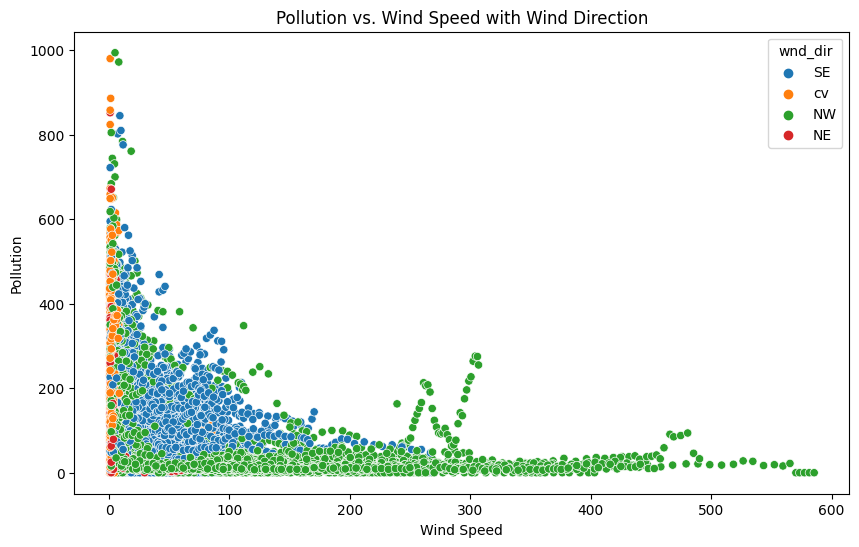

In [5]:
# plot pollution with variance of wnd_spd and hue wnd_dir

plt.figure(figsize=(10, 6))
sns.scatterplot(x='wnd_spd', y='pollution', hue='wnd_dir', data=df)
plt.title('Pollution vs. Wind Speed with Wind Direction')
plt.xlabel('Wind Speed')
plt.ylabel('Pollution')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


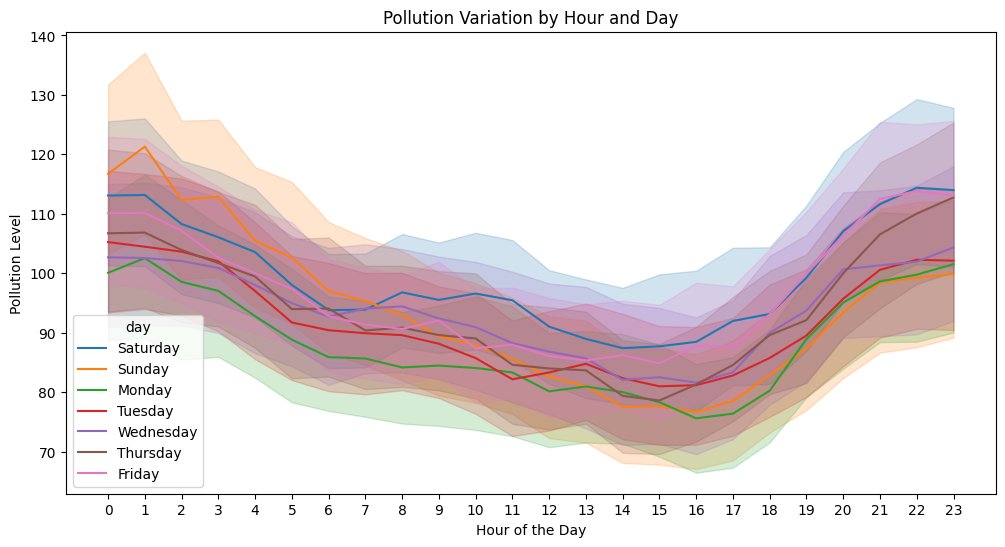

In [6]:

# Plotting pollution with variance of hour and day
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='pollution', hue='day', data=df)
plt.title('Pollution Variation by Hour and Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Pollution Level')
plt.xticks(range(24))  # Ensure all hours are displayed on the x-axis
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


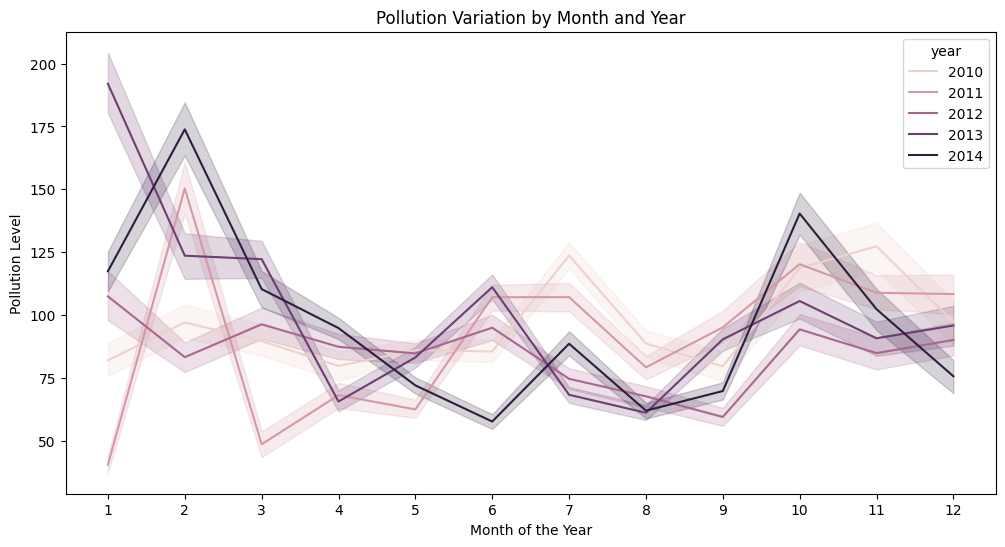

In [7]:

# Plotting pollution with variance of year
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='pollution', hue='year', data=df)
plt.title('Pollution Variation by Month and Year')
plt.xlabel('Month of the Year')
plt.ylabel('Pollution Level')
plt.xticks(range(1, 13))  # Ensure all months are displayed on the x-axis
plt.show()

In [8]:
# Replace object values in 'wnd_dir' with numerical values
wnd_dir_mapping = {
    'NE': 0,
    'NW': 1,
    'SE': 2,
    'cv': 3  # Add other directions as needed
}

df['wnd_dir'] = df['wnd_dir'].replace(wnd_dir_mapping)

In [9]:
# drop day column with object dtype

df.drop('day', axis=1, inplace=True)

In [10]:
# MinMaxScale all the feature columns also for pollution

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the selected columns
columns_to_scale = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,year,date_num,hour,month
0,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,2010,2,0,1
1,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,2010,2,1,1
2,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,2010,2,2,1
3,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,2010,2,3,1
4,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,2010,2,4,1


In [11]:
# create sequence with target prediction for pollution

def create_sequences(data, seq_length, target_col):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, target_col]  # Target is pollution
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 1  # Example sequence length (adjust as needed)
target_column_index = 0 # Index of the 'pollution' column (assuming it's the first)

X, y = create_sequences(df.values, seq_length, target_column_index)

# split into train and test sets:

train_size = int(len(X) * 0.8)  # Example: 80% for training
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print("Shape of training data X:", X_train.shape)
print("Shape of training data y:", y_train.shape)
print("Shape of testing data X:", X_test.shape)
print("Shape of testing data y:", y_test.shape)

Shape of training data X: (35038, 1, 12)
Shape of training data y: (35038,)
Shape of testing data X: (8760, 1, 12)
Shape of testing data y: (8760,)


In [12]:
# Build the GRU model

from tensorflow.keras.layers import GRU

model = Sequential()
model.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))  # Early Dropping
model.add(GRU(units=32))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 128)              │          54,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │          15,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,113 (273.88 KB)

 Trainable params: 70,113 (273.88 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Define early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data= (X_test,y_test), callbacks=[early_stopping])


Epoch 1/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0622 - val_loss: 0.0088
Epoch 2/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0138 - val_loss: 0.0088
Epoch 3/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 4/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 5/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 6/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 7/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 8/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 9/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 10/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 11/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 12/50
1095/1095 ━━━━━━━

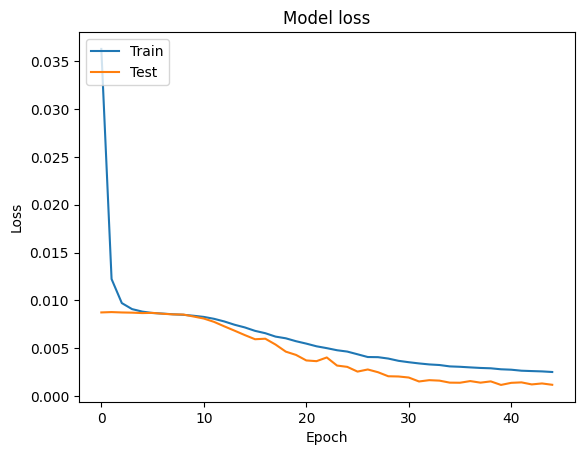

In [14]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)



274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 0.034356707524703246


In [16]:

# Reshape y_pred to have the same number of features the scaler was trained on
y_pred_reshaped = y_pred.reshape(-1, 1)

# Concatenate with zeros to match the original number of features before scaling
y_pred_rescaled = scaler.inverse_transform(np.concatenate([y_pred_reshaped, np.zeros((len(y_pred_reshaped), len(columns_to_scale) - 1))], axis=1))[:, 0]

# Reshape y_test to have the same number of features the scaler was trained on
y_test_reshaped = y_test.reshape(-1, 1)

# Concatenate with zeros to match the original number of features before scaling
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test_reshaped, np.zeros((len(y_test_reshaped), len(columns_to_scale) - 1))], axis=1))[:, 0]


# Now you can use y_pred_rescaled and y_test_rescaled for evaluation
rmse = math.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print('RMSE (Rescaled):', rmse)

RMSE (Rescaled): 34.15056727955503


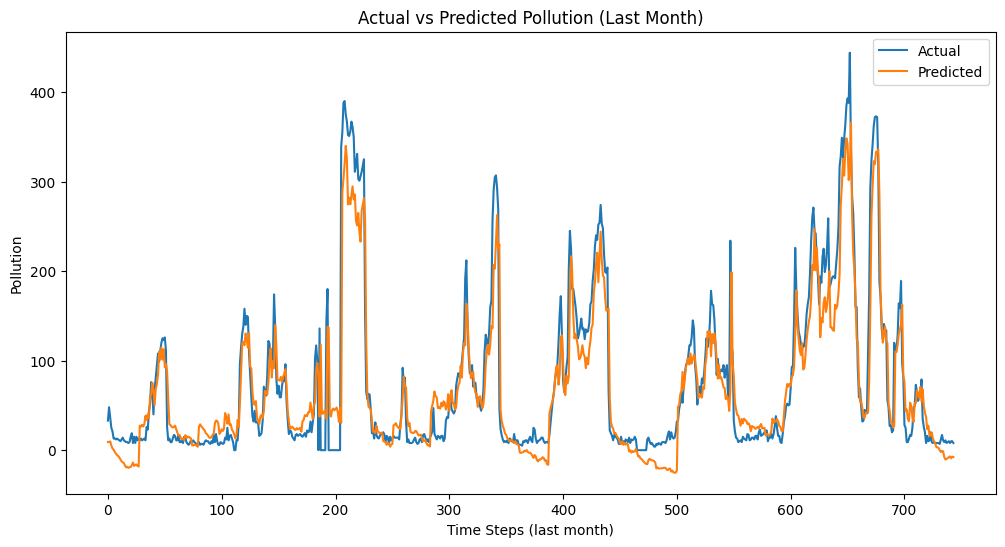

In [17]:
#  plot test vs predicted for last 1 month


last_month_data = df.iloc[-744:]

# Get corresponding predictions and actual values
last_month_predictions = y_pred_rescaled[-744:]
last_month_actual = y_test_rescaled[-744:]


plt.figure(figsize=(12, 6))
plt.plot(last_month_actual, label='Actual')
plt.plot(last_month_predictions, label='Predicted')
plt.xlabel('Time Steps (last month)')
plt.ylabel('Pollution')
plt.title('Actual vs Predicted Pollution (Last Month)')
plt.legend()
plt.show()

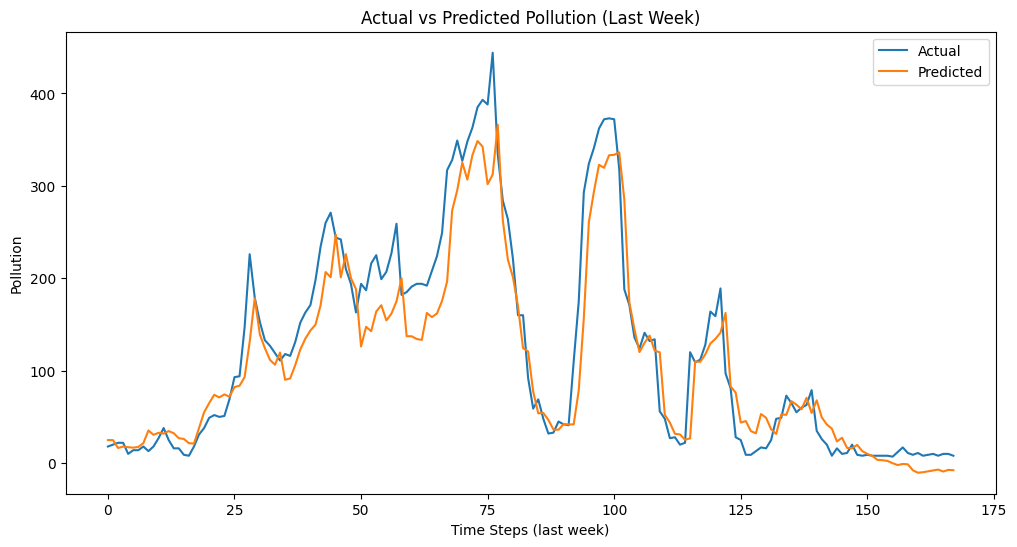

In [18]:
#  plot test vs predicted for last week


# Get the last week's data (assuming your data is hourly)
last_week_data = df.iloc[-168:]  # Last 168 hours (24 hours/day * 7 days)


# Get corresponding predictions and actual values
last_week_predictions = y_pred_rescaled[-168:]
last_week_actual = y_test_rescaled[-168:]

plt.figure(figsize=(12, 6))
plt.plot(last_week_actual, label='Actual')
plt.plot(last_week_predictions, label='Predicted')
plt.xlabel('Time Steps (last week)')
plt.ylabel('Pollution')
plt.title('Actual vs Predicted Pollution (Last Week)')
plt.legend()
plt.show()

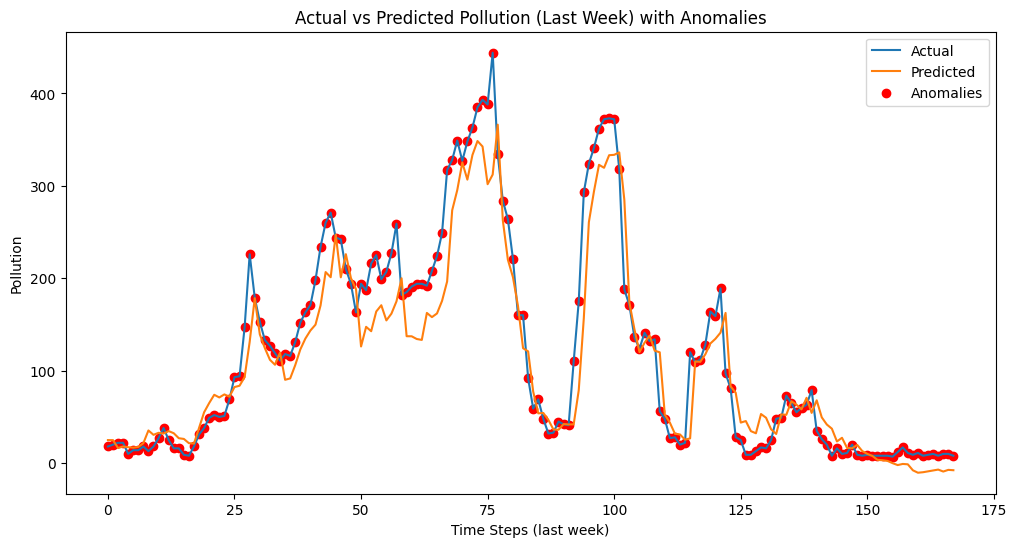

In [19]:
#  plot anomalies

# Calculate the absolute difference between actual and predicted values
errors = np.abs(last_week_actual - last_week_predictions)

# Define a threshold for anomaly detection (adjust as needed)
threshold = 0.1  # Example threshold: 10% difference

# Identify anomalies
anomalies = np.where(errors > threshold)[0]

# Plot the results with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(last_week_actual, label='Actual')
plt.plot(last_week_predictions, label='Predicted')
plt.scatter(anomalies, last_week_actual[anomalies], color='red', label='Anomalies')  # Highlight anomalies
plt.xlabel('Time Steps (last week)')
plt.ylabel('Pollution')
plt.title('Actual vs Predicted Pollution (Last Week) with Anomalies')
plt.legend()
plt.show()